# Restricted Boltzmann Machine

## Model derivation

The RBM derives from the Boltzmann Machine:

<img src="images/bm.png" width="250pt"/>

as an energy model:

$$\large p(x) = \frac{1}{Z}e^{-E(x)}$$

where the $x$ are chosen to be linearly dependent (with bias):

$$\large -E(x) = x^TWx + x^Tb$$

Factorizing $x = [v,h]$:

\begin{eqnarray}\large
-E(v,h) &=& \large [v,h]^TW[v,h] + [v,h]^Tb\\
        &=& \large v^TW_{vv}v + v^TW_{vh}h + h^TW_{hh}h + v^Tb_v + h^Tb_h\\
\end{eqnarray}

## RBM Model

The model is an __indirect bipartite graph__ obtained from Boltzmann Machines removing intra-layer dependencies:

<img src="images/rbm.png" width="350pt"/>

The associated energy function loose $W_{vv}$ and $W_{hh}$:

$$\large -E(v,h) = v^TWh + v^Tb_v + h^Tb_h$$

and the overall joint distribution is:

$$\large p(v,h) = \frac{1}{Z}e^{-E(v,h)}$$

Marginalizing, from $p(v,h)$ we can obtain the data distribution:

$$\large p(v) = \sum_h p(v,h) = \frac{1}{Z}\sum_h e^{-E(v,h)}$$

Unfortunately, in general $p(v)$ is computationally intractable (exponential combinations of $h$).

### The variable independences

The graphical model highlights:

* independece between $v_i$s given the $h$s,
* and independence between $h_j$s given the $v$s:

\begin{eqnarray}
\large p(v|h) &=& \large \prod_i p(v_i|h) \\
\large p(h|v) &=& \large \prod_j p(h_j|v)
\end{eqnarray}

Considering both $v$s and $h$s Bernoulli distributed, it can be shown that:

\begin{eqnarray}
\large p(v_i = 1|h) &=& \large \sigma\left( b_{v,i} + \sum_j w_{i,j}h_j\right) \\
\large p(h_j = 1|v) &=& \large \sigma\left( b_{h,j} + \sum_i w_{i,j}v_i \right) \\
\end{eqnarray}

where the sigmoid function $\sigma(\cdot)$ is $\sigma(x)=\frac{1}{1+e^{-x}}$.

### The algorithm

We whant to maximize the likelihood:

\begin{eqnarray}
\arg\max_\theta \log p(V) &=& \underset{\theta}{\operatorname{argmax}} 
                                \log\prod_{v \in V} p(v) \\
                          &=& \underset{\theta}{\operatorname{argmax}}
                                \sum_{v \in V}\log p(v) \\
                          &=& \underset{\theta}{\operatorname{argmax}}
                                \sum_{v \in V}\log e^{-E(v,h)} \\
                          &=& \underset{\theta = \left\{ W, b_v, b_h \right\}}{\operatorname{argmax}} 
                                \sum_{v \in V}\left( v^TWh + v^Tb_v + h^Tb_h \right) \\
\end{eqnarray}

To this aim... *gradient descent* (hill climbing).

The __Contrastive-Divergence__ (Hinton) iterates these steps for every $v$:

1. *Gibbs sampling*: take $v$, sample $h$ using $p(h|v)$, $v'$ using $p(v|h)$, $h'$ using $p(h|v)$
2. *parameters update*: update $W$, $b_v$, and $b_h$ with:
\begin{eqnarray}
    \Delta W &=& \epsilon\left(vh^T - v'h'^T\right) \\
    \Delta b_v &=& \epsilon\left(v - v'\right) \\
    \Delta b_h &=& \epsilon\left(h - h'\right) \\
\end{eqnarray}

Notice that:

\begin{eqnarray}
    \nabla \log p(V) 
        &=& \nabla \log \frac{\tilde{p}(V)}{Z} \\
        &=& \nabla \log \tilde{p}(V) - \nabla \log Z \\
\end{eqnarray}

highlights a __positive phase__ and a __negative phase__:

<img src="images/cd_phases.png" width="550pt"/>


## The MNIST dataset

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Loading the data:
(y_train, _), (y_test, _) = mnist.load_data()
y_train = np.random.permutation(y_train)
y_train = np.reshape(y_train/255.0,(y_train.shape[0],28*28))
y_test = np.reshape(y_test/255.0,(y_test.shape[0],28*28))
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)


## Creating and training the RBM

In [2]:
# Loading the tools:
%run RBM.py

# Creating an RBM with 256 hidden units:
rbm = RBM(nh=256, cd_steps=3)

# Executing the training:
losses = rbm.train(X=y_train, lr=0.001, epochs=25)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


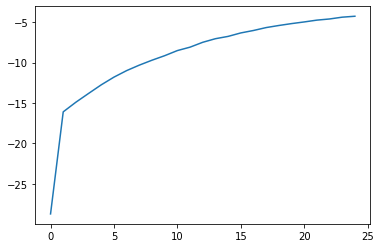

In [3]:
# Plotting the losses:
plt.plot(losses);

## The learned features

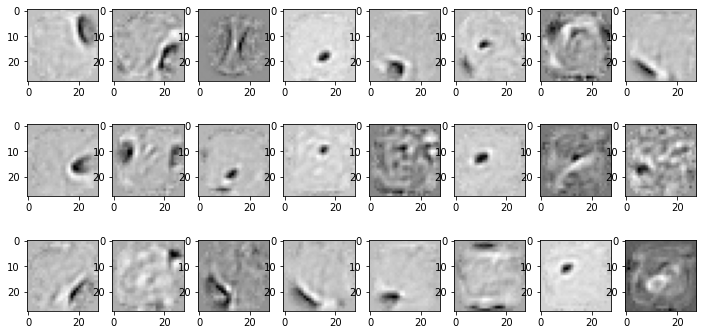

In [4]:
def mkimg(v,edge=28):
    return np.reshape(v,(edge,edge))

n,m = 3,8
W = rbm.model_W
plt.figure(figsize=(12,6))
plt.gray()
for i in range(n*m):
    plt.subplot(n,m,i+1)
    plt.imshow(mkimg(np.squeeze(W[:,i])));

## Encoding and decoding test images

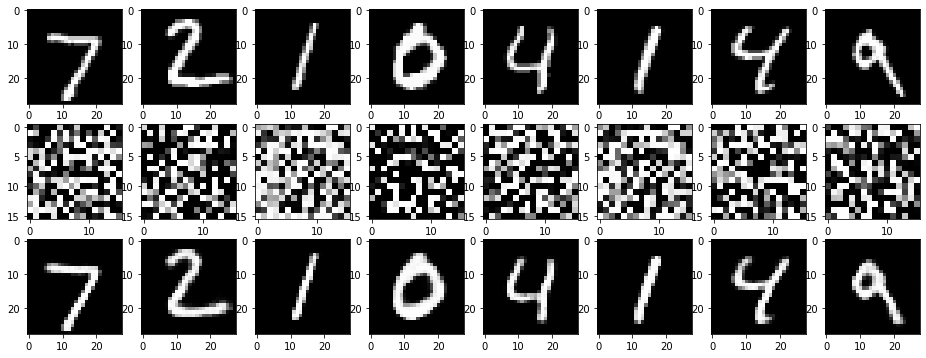

In [5]:
Nv = rbm.bv.shape[0]
Nh = rbm.bh.shape[0]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def decode_v(h):
    s = np.matmul(h,np.transpose(rbm.model_W))
    return sigmoid(s + rbm.model_bv)

def encode_h(v):
    s = np.matmul(v,rbm.model_W)
    return sigmoid(s + rbm.model_bh)

m = 8
plt.figure(figsize=(16,6))
for i in range(m):
    # Processing the image:
    img = y_test[i]
    h = encode_h(img)
    v = decode_v(h)
    
    # Plotting:
    plt.subplot(3,m,i+1)
    plt.imshow(mkimg(img))
    plt.subplot(3,m,i+1+m)
    plt.imshow(mkimg(h,16))
    plt.subplot(3,m,i+1+2*m)
    plt.imshow(mkimg(v));

<IPython.core.display.Javascript object>


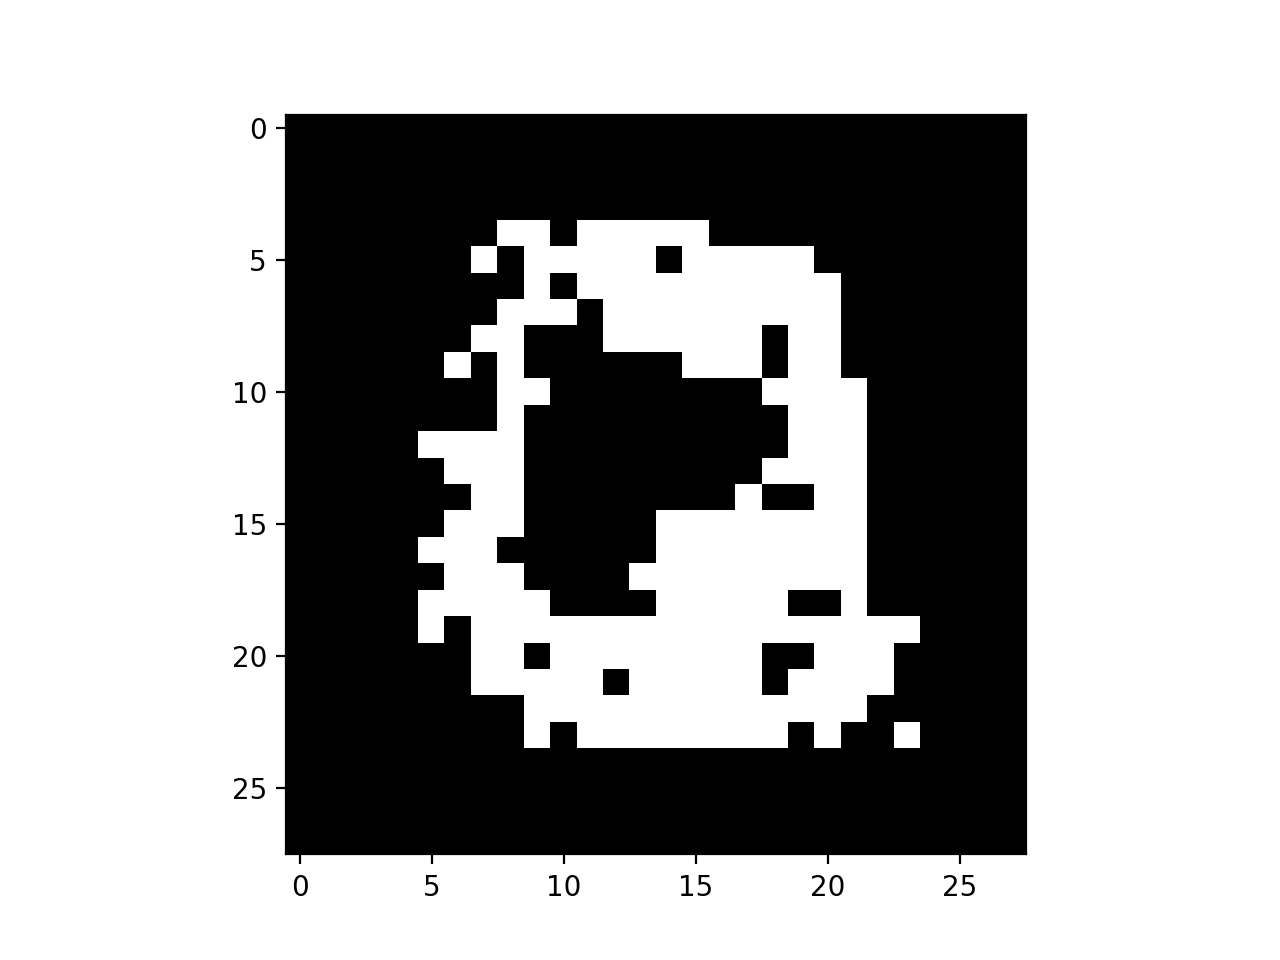

In [6]:
%matplotlib nbagg

from time import sleep
from matplotlib.animation import FuncAnimation


def rand(n):
    return np.random.uniform(size=(n,))


def bernoulli(p,n):
    return np.maximum(0,np.sign(p - rand(n)))


def sample_h(v):
    ph_given_v = sigmoid(np.matmul(v,rbm.model_W) + rbm.model_bh)
    return bernoulli(ph_given_v,Nh)


def sample_v(h):
    pv_given_h = sigmoid(np.matmul(h,np.transpose(rbm.model_W)) + rbm.model_bv)
    return bernoulli(pv_given_h,Nv)


def gibbs_sampling(v,cd_steps=1):
    for i in range(cd_steps):
        h = sample_h(v)
        v = sample_v(h)
    return v


def img_sequence(v):
    def next():
        global v
        v = gibbs_sampling(v)
        return mkimg(v)
    return next


def update(frame,f):
    img.set_data(f())

    
v = y_test[3]

fig = plt.figure()
img = plt.imshow(mkimg(v))
ani = FuncAnimation(fig, update,
                    frames=100,
                    interval=100,
                    fargs=(img_sequence(v),),
                    cache_frame_data=False)
plt.show();

## Deep Boltzmann Machines

Stacking of RBMs is possible with pretraining an halvening the weights:

<img src="images/dbm.png" width="550pt"/>
